In [ ]:
# Script for creating and training model, run on google colabs for fastest results

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import PIL
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import seaborn as sns

img_height = 128
img_width = 128
batch_size = 32

In [ ]:
#connect your google drive to the notebook on google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# numpy file of correct name needs to be uploaded in your google drive. change path as required
# the numpy file contains all the data for training
# use the create_training_data_array.py file to create this npy file
td_array = np.load('drive/MyDrive/lego_project/td_array_7cat.npy', allow_pickle=True)


In [ ]:
# checking if GPU is enabled ingoogle collabs
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# functions for increasing contrast for images, using the second function at the moment as it has better results

def increase_contrast_little(s):
    npImage = s

    min=np.min(npImage)        # result=144
    max=np.max(npImage)        # result=216

    # Make a LUT (Look-Up Table) to translate image values
    LUT=np.zeros(256,dtype=np.uint8)
    LUT[min:max+1]=np.linspace(start=0,stop=255,num=(max-min)+1,endpoint=True,dtype=np.uint8)
    s_new = LUT[npImage]
    return s_new

def increase_contrast_more(s):
    minval = np.percentile(s, 2)
    maxval = np.percentile(s, 98)
    npImage = np.clip(s, minval, maxval)

    npImage = npImage.astype(int)

    min=np.min(npImage)        # result=144
    max=np.max(npImage)        # result=216

    # Make a LUT (Look-Up Table) to translate image values
    LUT=np.zeros(256,dtype=np.uint8)
    LUT[min:max+1]=np.linspace(start=0,stop=255,num=(max-min)+1,endpoint=True,dtype=np.uint8)
    s_clipped = LUT[npImage]
    return s_clipped

In [ ]:
# Convert the training data into list and randomize the order to get a fair split for testing and training data
training_data = td_array.tolist()
random.shuffle(training_data)

In [ ]:
# Create x and y lists for the images and its labels (i.e integers from 0 - 6) respectively
x = []
y = []  

for piece, label in training_data:
    x.append(piece)
    y.append(label)

In [ ]:
x = np.array(list(map(increase_contrast_more, x))) #increase contrast of images
x = np.array(x).reshape(-1,128,128,1) #reshape images for the model
y = np.asarray(y)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2) # split the data into testing and training sets

In [ ]:

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",
                        input_shape=(img_height,
                                    img_width,
                                    1)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    ])

model = keras.Sequential(
    [
        data_augmentation,
    
        layers.Rescaling(1./255, input_shape = (img_height,img_width,1)), #normalize the data input

        layers.Conv2D(128, 3, padding="same", activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),

        layers.Conv2D(64, 3, padding="same", activation='relu'), #should this be 16 or 32 units? try with more data
        layers.MaxPooling2D(pool_size=(2,2)),

        layers.Conv2D(32, 3, padding="same", activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        
        layers.Conv2D(16, 3, padding="same", activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        
        layers.Dropout(0.1),
        layers.Flatten(),
        layers.Dense(10,activation = 'relu'),
        layers.Dense(7,activation='softmax'), # number of output classes
        # softmax activation on the last layer will output a probability distribution over the output classes. The sum 
        # of all the probabilities will be equal to 1
        
    ]
)        



model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=[keras.losses.SparseCategoricalCrossentropy(from_logits=False),],
    metrics=["accuracy"],
)
# epochs = 25
#model_history = 

# if you don't need the training graphs, can just run model.fit(...)
# model.fit(x_train, y_train, epochs=200, verbose=2, validation_data=(x_test,y_test), batch_size=25)  #i think 25/32 is the best batch size 

# run this to get graphs of the training progress
model_history = model.fit(x_train, y_train, epochs=200, verbose=2, validation_data=(x_test,y_test), batch_size=25)  #i think 25/32 is the best batch size 


Epoch 1/200
191/191 - 20s - loss: 1.8599 - accuracy: 0.2182 - val_loss: 1.6822 - val_accuracy: 0.3073 - 20s/epoch - 103ms/step
Epoch 2/200
191/191 - 6s - loss: 1.6006 - accuracy: 0.3526 - val_loss: 1.4276 - val_accuracy: 0.4223 - 6s/epoch - 33ms/step
Epoch 3/200
191/191 - 6s - loss: 1.3934 - accuracy: 0.4656 - val_loss: 1.2113 - val_accuracy: 0.5281 - 6s/epoch - 31ms/step
Epoch 4/200
191/191 - 6s - loss: 1.2273 - accuracy: 0.5481 - val_loss: 1.0442 - val_accuracy: 0.6238 - 6s/epoch - 31ms/step
Epoch 5/200
191/191 - 6s - loss: 1.0878 - accuracy: 0.6027 - val_loss: 0.9726 - val_accuracy: 0.6280 - 6s/epoch - 32ms/step
Epoch 6/200
191/191 - 6s - loss: 1.0083 - accuracy: 0.6205 - val_loss: 0.8209 - val_accuracy: 0.6935 - 6s/epoch - 31ms/step
Epoch 7/200
191/191 - 6s - loss: 0.9504 - accuracy: 0.6424 - val_loss: 0.8090 - val_accuracy: 0.6935 - 6s/epoch - 31ms/step
Epoch 8/200
191/191 - 6s - loss: 0.8669 - accuracy: 0.6732 - val_loss: 0.7835 - val_accuracy: 0.7003 - 6s/epoch - 31ms/step
Epoch

In [ ]:
# to get confusion matrix for model with test data
# By definition a confusion matrix C is such that C(i,j) is equal to the number of observations known to be in group i and predicted to be in group j
# columns are predictions, rows are actual labels

prediction = model.predict(x_test)
classes_x=np.argmax(prediction,axis=1)
cm = confusion_matrix(y_test, classes_x)
print(cm)
#print(prediction)

[[202   2  25   0   0   2   0]
 [  6 194   0   0   1   1   4]
 [  3   0 196   1   0   0   0]
 [  0   0   0 131   0   0   0]
 [  2   0   1   1  87   0   1]
 [  1   2   0   0   0 203   0]
 [  2   3   1   2   1   0 116]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


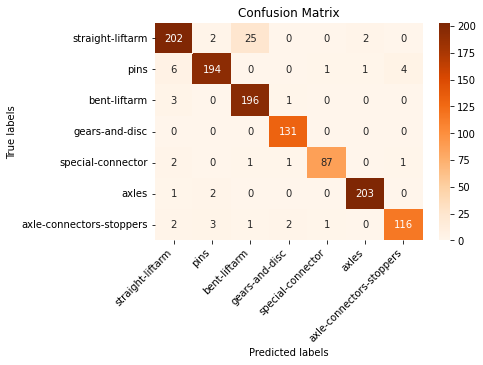

In [ ]:
#clearer visual representation of confusion matrix

categories = ["straight-liftarm", 'pins', 'bent-liftarm', 'gears-and-disc', 'special-connector', 'axles', 'axle-connectors-stoppers']

sns.heatmap(cm, cmap = "Oranges", annot = True, fmt='g')
ax= plt.subplot()

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.set_xticklabels(categories, rotation = 45, ha="right")
ax.set_yticklabels(categories, rotation = 0)

plt.show()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


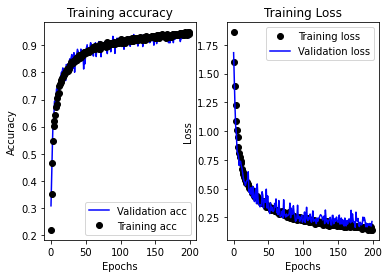

In [ ]:
# Graphically represent model performance.
# First plot shows validation and training accuracy, second plot shows validation and training loss
epochs = 200
history_dict = model_history.history
print(history_dict.keys())
val_loss_values = history_dict['val_loss']
training_loss_values = history_dict['loss']
training_acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs_range = range(epochs)  

plt.subplot(1,2,1)
plt.plot(epochs_range, val_acc_values, 'b', label='Validation acc')
plt.plot(epochs_range, training_acc_values, 'ko', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)  
plt.plot(epochs_range, training_loss_values, 'ko', label='Training loss')
plt.plot(epochs_range, val_loss_values, 'b', label='Validation loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Save the entire model as a SavedModel.
model.save('drive/MyDrive/lego_project/saved_model/final_model')  
# This will create a SavedModel named my_model in the saved_model folder

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('drive/MyDrive/lego_project/saved_model/final_model') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('drive/MyDrive/lego_project/model.tflite', 'wb') as f:
  f.write(tflite_model)  #save tfllite model as model.tflite


In [ ]:
# to load model
model_loaded = tf.keras.models.load_model('drive/MyDrive/lego_project/saved_model/my_model')